In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cupy as cp

In [3]:
import numpy as np
import pandas as pd
import tensorflow_text
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import clustering
from sentence_transformers import SentenceTransformer
from collections import Counter
from hyperopt import hp
import random
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adilbek.karmanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/adilbek.karmanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Reading tweet files

In [4]:
folder = 'files/'
df_with_sw = pd.read_csv(folder + 'clean_tweets_with_stopwords.csv')
df_without_sw = pd.read_csv(folder + 'clean_tweets_without_stopwords.csv')

In [5]:
#Extract tweet data
tweets_with_sw = df_with_sw['tweet']
tweets_without_sw = df_without_sw['tweet']

### Getting encodings using Bag of Words

In [6]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
embeddings_bow = cp.asarray(bow_vectorizer.fit_transform(tweets_without_sw).toarray())

### Getting encodings using TF-IDF

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
embeddings_tfidf = cp.asarray(tfidf_vectorizer.fit_transform(tweets_without_sw).toarray())

### Getting encodings using Word2Vec

In [8]:
embeddings_wordvec = cp.asarray(clustering.word2vec(tweets_without_sw))

### Getting encodings using different Transformer Encoder models

In [9]:
model_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
model_mpnet = SentenceTransformer('all-mpnet-base-v2', device="cpu")
model_minilm = SentenceTransformer('all-MiniLM-L6-v2', device="cpu")
model_distil = SentenceTransformer('all-distilroberta-v1', device="cpu")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
2021-12-02 03:08:37.078264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-02 03:08:37.078504: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-02 03:08:37.078825: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropria

In [ ]:
embeddings_use = cp.asarray(model_use(tweets_with_sw))
embeddings_mpnet = cp.asarray(model_mpnet.encode(tweets_with_sw, show_progress_bar=True))
embeddings_minilm = cp.asarray(model_minilm.encode(tweets_with_sw, show_progress_bar=True))
embeddings_distil = cp.asarray(model_distil.encode(tweets_with_sw, show_progress_bar = True))

Batches:   0%|          | 0/382 [00:00<?, ?it/s]

### UMAP + HDBSCAN with different encoding techniques

#### Bag of Words:

In [ ]:
clusters_bow, score_bow = clustering.generate_clusters(embeddings_bow,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=50,
                                                    min_cluster_size=120
                                                    )

Label prop iterations: 21
Label prop iterations: 9
Label prop iterations: 4
Iterations: 3
2774,90,247,14,144,883


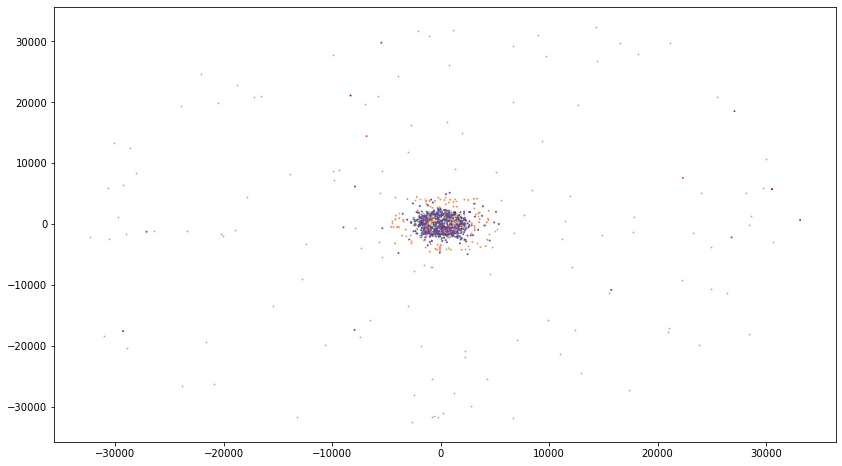

In [ ]:
clustering.plot_clusters(embeddings_bow, clusters_bow, n_neighbors=150, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_without_sw, clusters_bow.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,1764,"[haha, yes, amp, welcome, youre, yup, absolute...","[120, 69, 61, 51, 42, 42, 39, 38, 38, 37]"
1,0,126,"[ok, glad, youre, haha, engines, fine, 3owners...","[110, 13, 10, 3, 3, 3, 3, 3, 2, 2]"
2,1,165,"[coming, soon, point, good, tesla, amp, one, l...","[94, 91, 52, 49, 17, 8, 6, 5, 5, 5]"
3,2,434,"[yes, amp, 1, lot, 7, good, 3, much, 13031925,...","[432, 14, 9, 8, 8, 8, 7, 7, 7, 7]"
4,3,196,"[true, haha, actually, amp, still, tesla, many...","[189, 31, 15, 10, 6, 6, 5, 5, 4, 4]"
5,4,183,"[sure, make, amp, hope, 1, way, need, yes, 45,...","[179, 15, 11, 9, 7, 7, 7, 6, 5, 5]"
6,5,147,"[exactly, good, 1, amp, many, actually, thats,...","[147, 6, 6, 5, 5, 5, 5, 5, 4, 4]"
7,6,144,"[cool, course, would, interesting, love, still...","[84, 46, 15, 10, 9, 8, 8, 6, 6, 6]"
8,7,149,"[yeah, like, hard, make, amp, would, thats, im...","[149, 8, 8, 7, 7, 6, 6, 5, 5, 5]"
9,8,8616,"[amp, tesla, good, model, like, great, 3, woul...","[1785, 981, 403, 390, 371, 360, 343, 312, 308,..."


#### TF-IDF:

In [ ]:
clusters_tfidf, score_tfidf = clustering.generate_clusters(embeddings_tfidf,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=50,
                                                    min_cluster_size=200
                                                    )

Label prop iterations: 20
Label prop iterations: 6
Label prop iterations: 5
Iterations: 3
2494,85,247,12,137,768


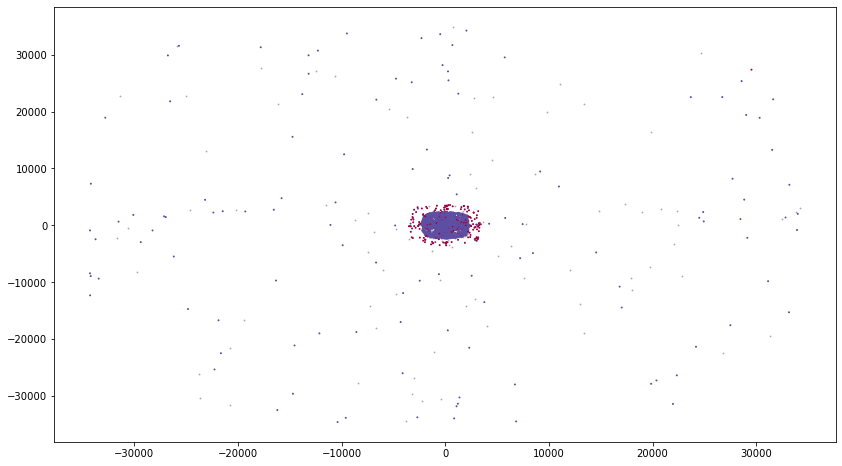

In [ ]:
clustering.plot_clusters(embeddings_tfidf, clusters_tfidf, n_neighbors=200, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_without_sw, clusters_tfidf.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,1104,"[amp, tesla, car, 3, would, model, high, time,...","[265, 135, 55, 54, 51, 51, 43, 41, 41, 39]"
1,0,311,"[yes, 7, 1, 8, um, 3, done, 2908, 5, 6]","[295, 7, 5, 4, 3, 3, 3, 2, 2, 2]"
2,1,10509,"[amp, tesla, good, like, great, model, would, ...","[1641, 916, 447, 372, 368, 353, 329, 321, 286,..."


#### Word2vec:

In [ ]:
clusters_wordvec, score_wordvec = clustering.generate_clusters(embeddings_wordvec,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=70,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 21
Label prop iterations: 9
Label prop iterations: 6
Iterations: 3
3328,77,284,12,129,823


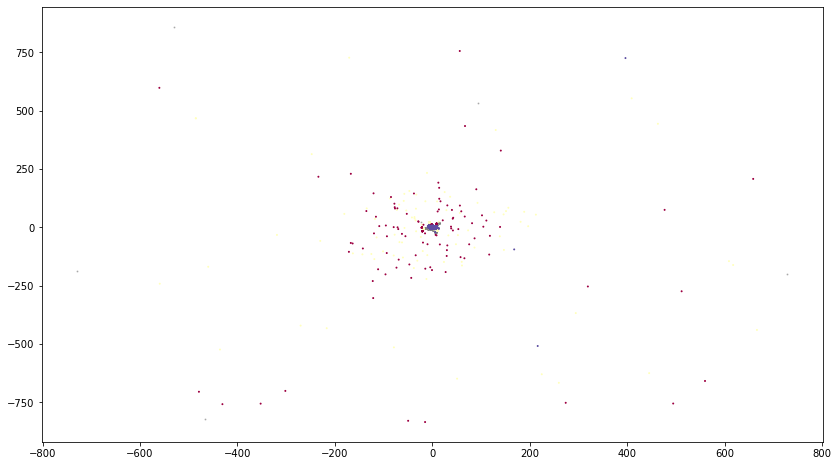

In [ ]:
clustering.plot_clusters(embeddings_wordvec, clusters_wordvec, n_neighbors = 50, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_without_sw, clusters_wordvec.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,274,"[true, sure, thanks, much, yup, pretty, absolu...","[49, 45, 34, 29, 28, 22, 19, 17, 17, 9]"
1,0,337,"[yes, exactly, yeah, 3201, 1stprinciples4l, 7x...","[238, 68, 31, 1, 1, 1, 1, 1, 1, 1]"
2,1,319,"[ok, haha, sure, touché, yup, hg2g, samwise, n...","[52, 44, 18, 3, 3, 2, 2, 2, 2, 2]"
3,2,10994,"[amp, tesla, good, like, model, great, would, ...","[1908, 1053, 488, 405, 404, 390, 381, 378, 330..."


#### USE:

In [ ]:
clusters_use, score_use = clustering.generate_clusters(embeddings_use,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=90,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 22
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
2752,93,387,14,166,860


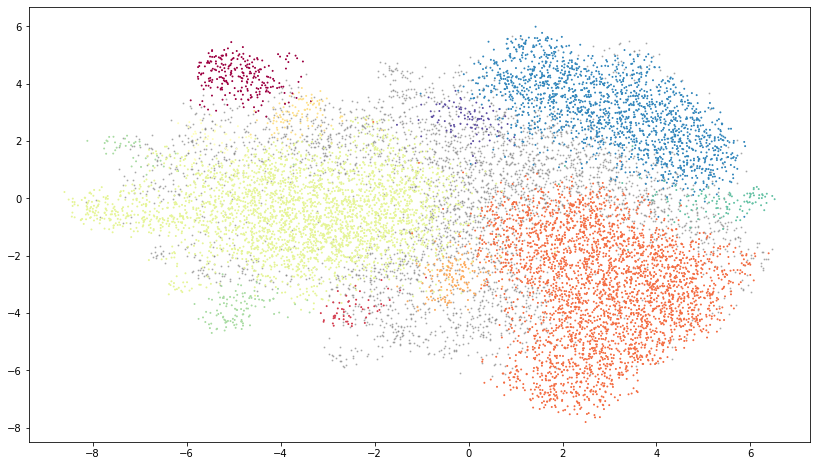

In [ ]:
clustering.plot_clusters(embeddings_use, clusters_use, n_neighbors=30, min_dist=1.0)

In [ ]:
tweets_without_sw.shape

(11924,)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_use.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3477,"[amp, erdayastronaut, good, model, tesla, like...","[452, 146, 146, 129, 123, 111, 109, 106, 103, ..."
1,0,243,"[nichegamer, ppathole, theonion, rationaletien...","[10, 7, 7, 6, 4, 4, 4, 4, 4, 3]"
2,1,54,"[twitter, tweets, mkbhd, tweet, reddit, real, ...","[31, 8, 7, 7, 7, 3, 3, 3, 3, 2]"
3,2,3097,"[tesla, amp, model, car, cars, production, goo...","[1691, 984, 331, 273, 195, 171, 148, 132, 132,..."
4,3,149,"[amp, media, people, public, like, know, would...","[40, 26, 18, 16, 10, 10, 10, 8, 8, 8]"
5,4,96,"[flcnhvy, teslaownerssv, grimezsz, kristennett...","[9, 6, 5, 5, 5, 5, 4, 3, 3, 3]"
6,5,52,"[haha, ahem, lol, evafoxu, lexfridman, trouble...","[30, 4, 4, 3, 2, 2, 2, 2, 1, 1]"
7,6,3016,"[yes, flcnhvy, great, erdayastronaut, exactly,...","[308, 122, 107, 92, 89, 88, 78, 76, 76, 70]"
8,7,145,"[true, sure, haha, flcnhvy, teslaownerssv, cle...","[96, 30, 15, 13, 6, 6, 4, 4, 4, 3]"
9,8,108,"[tunnel, boring, tunnels, amp, la, company, fi...","[60, 32, 29, 19, 19, 16, 14, 10, 10, 9]"


#### MPNET

In [ ]:
clusters_mpnet, score_mpnet = clustering.generate_clusters(embeddings_mpnet,
                                                   n_neighbors=30,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=90,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 26
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 3
Iterations: 4
2749,92,384,13,162,918


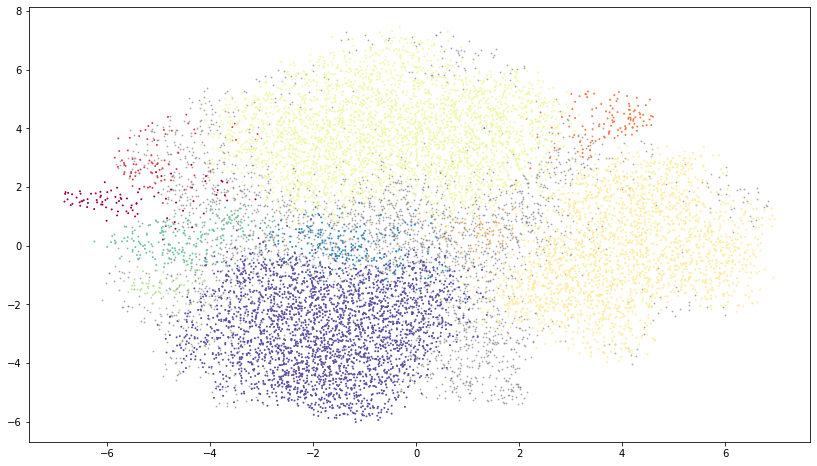

In [ ]:
clustering.plot_clusters(embeddings_mpnet, clusters_mpnet, n_neighbors=30, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_mpnet.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3147,"[amp, tesla, good, erdayastronaut, like, yes, ...","[485, 153, 134, 127, 119, 110, 108, 107, 100, 93]"
1,0,91,"[amp, positive, c, false, covid, test, cov, pc...","[39, 23, 22, 20, 18, 17, 14, 14, 14, 14]"
2,1,78,"[cleantechnica, ventilators, amp, tesla, delay...","[54, 16, 15, 12, 6, 6, 5, 5, 4, 4]"
3,2,119,"[tunnel, boring, tunnels, amp, boringcompany, ...","[58, 36, 35, 34, 19, 17, 17, 15, 15, 12]"
4,3,56,"[engineers, feed, flamethrower, yes, flamethro...","[31, 31, 7, 4, 4, 4, 3, 3, 2, 2]"
5,4,2239,"[spacex, amp, erdayastronaut, rocket, starship...","[580, 449, 399, 222, 183, 182, 175, 172, 147, ..."
6,5,3167,"[tesla, amp, model, car, teslaownerssv, cars, ...","[1614, 786, 419, 294, 207, 191, 154, 147, 146,..."
7,6,76,"[twitter, tweets, jack, tweet, real, people, a...","[41, 8, 7, 7, 6, 6, 6, 5, 5, 5]"
8,7,214,"[amp, media, public, people, true, article, go...","[45, 31, 19, 17, 14, 12, 11, 10, 10, 10]"
9,8,218,"[worldandscience, amp, fermatslibrary, wondero...","[21, 11, 11, 10, 10, 10, 10, 9, 8, 8]"


#### MiniLM

In [ ]:
clusters_minilm, score_minilm = clustering.generate_clusters(embeddings_minilm,
                                                   n_neighbors=25,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=30,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 23
Label prop iterations: 9
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
2484,120,282,16,222,2192


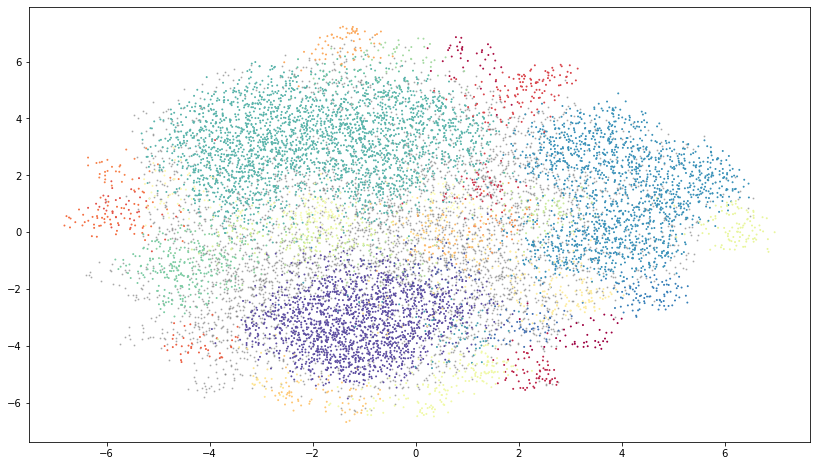

In [ ]:
clustering.plot_clusters(embeddings_minilm, clusters_minilm, n_neighbors=25, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_minilm.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3907,"[amp, tesla, erdayastronaut, spacex, yes, grea...","[577, 326, 177, 154, 143, 142, 135, 130, 120, ..."
1,0,40,"[id, aa, carmack, soumiksf, would, must, hope,...","[39, 39, 39, 4, 3, 2, 2, 2, 2, 2]"
2,1,39,"[roof, solar, tesla, solarglass, amp, glass, t...","[36, 28, 25, 9, 8, 6, 6, 5, 5, 4]"
3,2,65,"[nichegamer, justpaulinelol, flcnhvy, little, ...","[60, 4, 4, 3, 3, 3, 3, 3, 3, 3]"
4,3,53,"[engineers, feed, engineering, yes, haha, like...","[48, 47, 5, 4, 4, 4, 3, 3, 3, 3]"
5,4,127,"[tunnel, boring, tunnels, amp, la, boringcompa...","[58, 39, 37, 32, 21, 20, 20, 16, 15, 11]"
6,5,37,"[climate, change, global, warming, scientists,...","[26, 23, 7, 7, 6, 4, 3, 3, 3, 3]"
7,6,40,"[fredericlambert, electrekco, yeah, still, for...","[40, 10, 3, 3, 2, 2, 2, 2, 2, 2]"
8,7,63,"[amp, positive, c, false, test, covid, pcr, co...","[26, 22, 21, 19, 16, 16, 14, 13, 13, 12]"
9,8,32,"[ventilators, amp, tesla, hospitals, invasive,...","[26, 15, 12, 9, 7, 7, 6, 5, 5, 4]"


#### DistilBERT

In [ ]:
clusters_distil, score_distil = clustering.generate_clusters(embeddings_distil,
                                                   n_neighbors=25,
                                                    n_components=2,
                                                    random_state=42,
                                                     min_samples=30,
                                                    min_cluster_size=30
                                                    )

Label prop iterations: 24
Label prop iterations: 7
Label prop iterations: 8
Label prop iterations: 2
Label prop iterations: 3
Iterations: 5
2235,121,274,16,218,1071


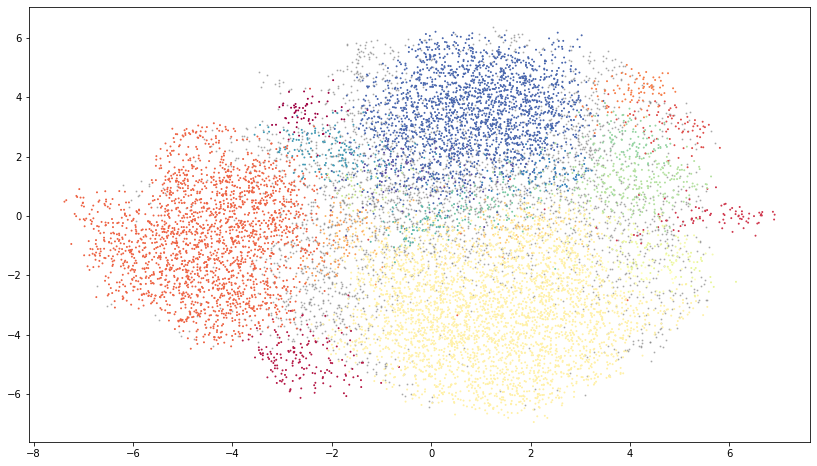

In [ ]:
clustering.plot_clusters(embeddings_distil, clusters_distil, n_neighbors=25, min_dist=1.0)

In [ ]:
clustering.top_ten_words(tweets_with_sw, clusters_distil.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,2993,"[amp, tesla, good, yes, like, great, flcnhvy, ...","[405, 198, 126, 119, 103, 96, 93, 88, 86, 80]"
1,0,65,"[erdayastronaut, tobyliiiiiiiiii, yes, sure, y...","[57, 12, 9, 8, 5, 4, 3, 3, 3, 2]"
2,1,164,"[tunnel, hyperloop, amp, tunnels, boring, bori...","[62, 38, 37, 35, 35, 19, 19, 19, 15, 14]"
3,2,87,"[amp, positive, c, symptoms, false, covid, tes...","[36, 21, 21, 19, 19, 18, 16, 14, 14, 14]"
4,3,76,"[ppathole, yes, amp, great, haha, flcnhvy, tru...","[72, 6, 5, 3, 3, 3, 3, 2, 2, 2]"
5,4,2125,"[spacex, amp, erdayastronaut, rocket, launch, ...","[582, 428, 402, 223, 186, 182, 180, 172, 154, ..."
6,5,89,"[cleantechnica, rationaletienne, true, interes...","[51, 28, 5, 4, 4, 3, 3, 3, 3, 3]"
7,6,72,"[engineers, feed, id, aa, carmack, like, yes, ...","[40, 39, 29, 29, 29, 6, 4, 3, 3, 3]"
8,7,32,"[la, texas, beautiful, south, amp, weather, to...","[5, 5, 4, 4, 3, 3, 3, 3, 2, 2]"
9,8,108,"[ai, openai, amp, flamethrower, open, flamethr...","[52, 20, 15, 15, 7, 7, 6, 6, 6, 5]"


### Adding cluster labels to the dataframes

In [ ]:
df_without_sw['cluster_bow_default'] = clusters_bow.labels_.get()
df_without_sw['cluster_tfidf_default'] = clusters_tfidf.labels_.get()
df_without_sw['cluster_word2vec_default'] = clusters_wordvec.labels_.get()

In [ ]:
df_with_sw['cluster_use_default'] = clusters_use.labels_.get()
df_with_sw['cluster_mpnet_default'] = clusters_mpnet.labels_.get()
df_with_sw['cluster_minilm_default'] = clusters_minilm.labels_.get()
df_with_sw['cluster_distilbert_default'] = clusters_distil.labels_.get()

In [ ]:
#df_with_sw.to_csv('files/clusterized_tweets_with_stopwords.csv')
#df_without_sw.to_csv('files/clusterized_tweets_without_stopwords.csv')

### Hyperparameters tuning using Gaussian Optimization

In [ ]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(2,100)),
    "n_components": hp.choice('n_components', range(2,100)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2,200)),
    'min_samples': hp.choice('min_samples', range(2,200)),
    "random_state": 42
}

max_evals = 15

In [ ]:
best_params_bow, best_clusters_bow, trials_bow = clustering.bayesian_search(embeddings_bow, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 16
Label prop iterations: 5
Label prop iterations: 2
Iterations: 3
3141,71,350,12,121,448
  7%|▋         | 1/15 [00:18<04:24, 18.86s/trial, best loss: -0.3810876480843184]Label prop iterations: 18
Label prop iterations: 5
Label prop iterations: 2
Iterations: 3
2469,70,251,11,119,459
 13%|█▎        | 2/15 [00:38<04:12, 19.43s/trial, best loss: -0.3810876480843184]Label prop iterations: 17
Label prop iterations: 3
Label prop iterations: 2
Iterations: 3
3048,72,352,11,122,422
 20%|██        | 3/15 [01:03<04:23, 21.97s/trial, best loss: -0.3810876480843184]Label prop iterations: 19
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
2166,85,277,11,155,563
 27%|██▋       | 4/15 [01:23<03:51, 21.04s/trial, best loss: -0.3810876480843184]Label prop iterations: 20
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
2484,68,270,12,114,475
 33%|███▎      | 5/15 [01:48<03:

In [ ]:
best_params_tfidf, best_clusters_tfidf, trials_tfidf = clustering.bayesian_search(embeddings_tfidf, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 19
Label prop iterations: 5
Iterations: 2
2452,56,220,8,93,444
  7%|▋         | 1/15 [00:03<00:47,  3.39s/trial, best loss: -0.023929329726599124]Label prop iterations: 23
Label prop iterations: 7
Label prop iterations: 4
Iterations: 3
2136,69,244,10,115,599
 13%|█▎        | 2/15 [00:04<00:29,  2.25s/trial, best loss: -0.14348884761433825] Label prop iterations: 16
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 2
Iterations: 5
1519,92,177,14,185,620
Label prop iterations: 4
Label prop iterations: 3
Iterations: 2
1327,47,68,6,84,168
 20%|██        | 3/15 [00:20<01:39,  8.33s/trial, best loss: -0.14348884761433825]Label prop iterations: 22
Label prop iterations: 8
Label prop iterations: 2
Iterations: 3
2185,71,246,11,115,560
 27%|██▋       | 4/15 [00:29<01:35,  8.71s/trial, best loss: -0.14348884761433825]Label prop iterations: 23
Label prop iterations: 6
Label 

In [ ]:
best_params_wordvec, best_clusters_wordvec, trials_wordvec = clustering.bayesian_search(embeddings_wordvec, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 25
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
3367,70,397,10,118,622
Label prop iterations: 2
Iterations: 1
1398,35,47,5,41,69
  7%|▋         | 1/15 [00:28<06:43, 28.82s/trial, best loss: -0.15949970672464017]Label prop iterations: 20
Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 4
Iterations: 4
1816,90,160,13,170,721
Label prop iterations: 3
Iterations: 1
1313,35,47,5,39,82
 13%|█▎        | 2/15 [00:54<05:53, 27.18s/trial, best loss: -0.23369875778324928]Label prop iterations: 29
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
3392,77,386,12,133,652
Label prop iterations: 2
Iterations: 1
1426,34,46,5,43,72
 20%|██        | 3/15 [01:23<05:34, 27.88s/trial, best loss: -0.23369875778324928]Label prop iterations: 28
Label prop iterations: 2
Label prop iterations: 3
Iterations: 3
3290,81,372,13,125,641
Label prop iterations: 3
Iterations: 1
2047,35,48

In [ ]:
best_params_use, best_clusters_use, trials_use = clustering.bayesian_search(embeddings_use, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 30
Label prop iterations: 3
Label prop iterations: 2
Iterations: 3
2874,74,323,12,130,631
  7%|▋         | 1/15 [00:03<00:55,  3.94s/trial, best loss: -0.26399099981980656]Label prop iterations: 29
Label prop iterations: 5
Label prop iterations: 2
Label prop iterations: 2
Iterations: 4
2421,85,326,12,164,716
 13%|█▎        | 2/15 [00:07<00:50,  3.89s/trial, best loss: -0.26399099981980656]Label prop iterations: 32
Label prop iterations: 6
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
2320,98,292,14,177,841
 20%|██        | 3/15 [00:10<00:41,  3.48s/trial, best loss: -0.26399099981980656]Label prop iterations: 31
Label prop iterations: 7
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
1918,86,217,13,181,746
 27%|██▋       | 4/15 [00:17<00:51,  4.68s/trial, best loss: -0.26399099981980656]Label prop iterations: 18
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
3

In [ ]:
best_params_mpnet, best_clusters_mpnet, trials_mpnet = clustering.bayesian_search(embeddings_mpnet, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 21
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
2380,79,321,11,132,576
  7%|▋         | 1/15 [00:04<01:04,  4.58s/trial, best loss: -0.27907211405086746]Label prop iterations: 22
Label prop iterations: 9
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 2
Iterations: 5
1417,96,181,15,184,796
Label prop iterations: 2
Iterations: 1
1334,33,47,4,40,69
 13%|█▎        | 2/15 [00:28<03:25, 15.82s/trial, best loss: -0.27907211405086746]Label prop iterations: 26
Label prop iterations: 6
Label prop iterations: 3
Label prop iterations: 2
Iterations: 4
2183,87,290,14,162,682
 20%|██        | 3/15 [00:52<03:56, 19.73s/trial, best loss: -0.27907211405086746]Label prop iterations: 22
Label prop iterations: 6
Label prop iterations: 2
Label prop iterations: 2
Iterations: 4
2314,83,299,12,154,593
 27%|██▋       | 4/15 [01:16<03:53, 21.25s/trial, best loss: -0.2

In [ ]:
best_params_minilm, best_clusters_minilm, trials_minilm = clustering.bayesian_search(embeddings_minilm, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 21
Label prop iterations: 3
Label prop iterations: 3
Iterations: 3
3392,77,378,12,140,534
  7%|▋         | 1/15 [00:06<01:37,  6.94s/trial, best loss: -0.3180966832101423]Label prop iterations: 21
Label prop iterations: 5
Label prop iterations: 5
Label prop iterations: 2
Iterations: 4
1992,82,217,11,155,627
 13%|█▎        | 2/15 [00:11<01:09,  5.36s/trial, best loss: -0.3180966832101423]Label prop iterations: 23
Label prop iterations: 4
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
2192,79,301,11,146,654
 20%|██        | 3/15 [00:15<00:59,  4.99s/trial, best loss: -0.3180966832101423]Label prop iterations: 17
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 4
Label prop iterations: 4
Iterations: 5
1381,102,175,14,195,767
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
1297,45,69,6,78,153
Label prop iterations: 2
Iterations: 1
1320,32,46,5,38,67
 27%|██▋

In [ ]:
best_params_distil, best_clusters_distil, trials_distil = clustering.bayesian_search(embeddings_distil, 
                                                                 space=hspace,  
                                                                 max_evals=max_evals)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]Label prop iterations: 26
Label prop iterations: 5
Label prop iterations: 3
Iterations: 3
2325,74,265,11,121,587
  7%|▋         | 1/15 [00:04<01:02,  4.48s/trial, best loss: -0.18790650558397815]Label prop iterations: 22
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 3
Iterations: 4
1832,107,206,11,150,646
 13%|█▎        | 2/15 [00:08<00:57,  4.41s/trial, best loss: -0.2461063556766056] Label prop iterations: 19
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
3187,70,362,12,119,484
 20%|██        | 3/15 [00:13<00:53,  4.44s/trial, best loss: -0.2756579395624683]Label prop iterations: 18
Label prop iterations: 5
Label prop iterations: 3
Iterations: 3
2572,76,283,9,117,466
 27%|██▋       | 4/15 [00:17<00:48,  4.42s/trial, best loss: -0.2756579395624683]Label prop iterations: 19
Label prop iterations: 4
Label prop iterations: 3
Iterations: 3
2460,67,275,11,128,510
 33%|███▎      | 5/15 [00:21<0

In [ ]:
columns = list(['name']) + list(best_params_distil.keys()) + list(trials_distil.best_trial['result'].keys())
bow_row = list(['BoW']) + list(best_params_bow.values()) + list(trials_bow.best_trial['result'].values())
tfidf_row = list(['TF-IDF']) + list(best_params_tfidf.values()) + list(trials_tfidf.best_trial['result'].values())
wordvec_row = list(['Word2Vec']) + list(best_params_wordvec.values()) + list(trials_wordvec.best_trial['result'].values())
use_row = list(['USE']) + list(best_params_use.values()) + list(trials_use.best_trial['result'].values())
mpnet_row = list(['MPNET']) + list(best_params_mpnet.values()) + list(trials_mpnet.best_trial['result'].values())
minilm_row = list(['MiniLM']) + list(best_params_minilm.values()) + list(trials_minilm.best_trial['result'].values())
distil_row = list(['Distil Roberta']) + list(best_params_distil.values()) + list(trials_distil.best_trial['result'].values())

rows = [bow_row, tfidf_row, wordvec_row, use_row, mpnet_row, minilm_row, distil_row]

df_compare = pd.DataFrame(rows, columns = columns)

### Evaluate and save

In [ ]:
df_compare.head(10)

,name,min_cluster_size,min_samples,n_components,n_neighbors,random_state,loss,label_count,status
0,BoW,167,145,16,95,42,-0.442754,3,ok
1,TF-IDF,7,105,55,83,42,-0.314179,4,ok
2,Word2Vec,37,47,35,92,42,-0.438358,8,ok
3,USE,99,165,38,5,42,-0.291460,5,ok
4,MPNET,88,48,84,33,42,-0.429792,4,ok
5,MiniLM,70,84,64,11,42,-0.415998,3,ok
6,Distil Roberta,156,180,30,37,42,-0.328104,4,ok


In [ ]:
#Bag of words
clustering.top_ten_words(tweets_without_sw, best_clusters_bow.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,1580,"[yes, 1, 2, much, one, 3, done, 5, almost, would]","[102, 34, 21, 21, 19, 18, 16, 15, 14, 12]"
1,0,9953,"[amp, tesla, good, like, model, great, would, ...","[1888, 1043, 473, 402, 395, 383, 363, 353, 327..."
2,1,391,"[yes, amp, 1, lot, 7, 3, good, much, probably,...","[391, 13, 11, 9, 9, 7, 7, 6, 6, 6]"


In [ ]:
#TF-IDF
clustering.top_ten_words(tweets_without_sw, best_clusters_tfidf.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,3582,"[amp, tesla, car, exactly, would, 3, good, tru...","[888, 386, 166, 148, 143, 143, 136, 135, 135, ..."
1,0,261,"[yes, 1, 8, 7, um, 3, 2908, 5, 83, done]","[261, 5, 4, 3, 3, 3, 2, 2, 2, 2]"
2,1,9,"[exactly, 65, 777, 123denmark, 1bernard, 5912]","[9, 1, 1, 1, 1, 1]"
3,2,8072,"[amp, tesla, good, great, model, like, would, ...","[1020, 666, 352, 308, 277, 271, 238, 232, 220,..."


In [ ]:
#Word2vec
clustering.top_ten_words(tweets_without_sw, best_clusters_wordvec.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,272,"[haha, yes, yeah, sure, much, thanks, yup, pre...","[44, 43, 31, 28, 27, 27, 26, 22, 19, 17]"
1,0,37,"[sure, hope]","[37, 1]"
2,1,11013,"[amp, tesla, good, like, model, great, would, ...","[1908, 1053, 488, 405, 404, 390, 381, 378, 330..."
3,2,219,"[yes, 3201, 1stprinciples4l, 7xcp, 2serenity, ...","[219, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,3,210,"[touché, yup, hg2g, samwise, former, naturally...","[3, 3, 2, 2, 2, 2, 2, 2, 2, 2]"
5,4,69,"[exactly, 47280962, 5912, 1sthubblefan]","[69, 1, 1, 1]"
6,5,51,"[true, fact, 1995, 3301, sigh]","[51, 1, 1, 1, 1]"
7,6,53,"[ok, 1matthewgarcia, fine, 1219, 5042, 2192]","[53, 1, 1, 1, 1, 1]"


In [ ]:
#Universal sentence encoder
clustering.top_ten_words(tweets_with_sw, best_clusters_use.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,5871,"[amp, tesla, good, flcnhvy, great, like, true,...","[686, 246, 227, 205, 189, 186, 179, 162, 159, ..."
1,0,1971,"[spacex, amp, erdayastronaut, rocket, falcon, ...","[595, 482, 349, 229, 182, 175, 170, 127, 127, ..."
2,1,2495,"[tesla, amp, model, car, cars, production, goo...","[1570, 756, 299, 258, 181, 137, 122, 116, 111,..."
3,2,1549,"[yes, yeah, flcnhvy, erdayastronaut, great, pp...","[285, 71, 62, 55, 47, 46, 41, 40, 38, 37]"
4,3,327,"[flcnhvy, ppathole, rationaletienne, theonion,...","[17, 13, 10, 8, 7, 7, 7, 6, 6, 6]"


In [ ]:
#MPNET
clustering.top_ten_words(tweets_with_sw, best_clusters_mpnet.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,852,"[amp, cleantechnica, dmc, ryan, thirdrowtesla,...","[92, 79, 41, 41, 39, 34, 32, 31, 29, 28]"
1,0,189,"[amp, c, justpaulinelol, ppathole, ventilators...","[67, 29, 26, 25, 24, 23, 22, 20, 19, 19]"
2,1,11038,"[tesla, amp, spacex, erdayastronaut, yes, mode...","[1763, 1731, 683, 589, 537, 457, 442, 399, 367..."
3,2,134,"[tunnel, boring, amp, tunnels, boringcompany, ...","[61, 43, 37, 36, 21, 19, 18, 17, 16, 12]"


In [ ]:
#MiniLM
clustering.top_ten_words(tweets_with_sw, best_clusters_minilm.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,1719,"[amp, tesla, yes, nichegamer, like, good, grea...","[124, 90, 71, 59, 56, 56, 52, 51, 50, 48]"
1,0,10405,"[amp, tesla, spacex, erdayastronaut, yes, mode...","[1767, 1723, 676, 586, 502, 448, 426, 386, 350..."
2,1,89,"[amp, c, positive, false, covid, test, pcr, pp...","[36, 25, 22, 19, 17, 16, 14, 14, 13, 13]"


In [ ]:
#DistilBERT 
clustering.top_ten_words(tweets_with_sw, best_clusters_distil.labels_.get())

,Cluster,Size,Common words,Counts
0,-1,5469,"[amp, tesla, flcnhvy, good, great, yes, like, ...","[777, 277, 246, 213, 196, 195, 192, 169, 162, ..."
1,0,2075,"[spacex, amp, erdayastronaut, rocket, falcon, ...","[587, 433, 412, 227, 182, 180, 179, 173, 139, ..."
2,1,2250,"[yes, true, good, amp, haha, exactly, yeah, gr...","[204, 82, 69, 63, 62, 60, 59, 50, 49, 47]"
3,2,2419,"[tesla, amp, model, car, cars, autopilot, prod...","[1529, 654, 352, 285, 181, 114, 113, 107, 102,..."


In [ ]:
df_without_sw['cluster_bow_dbcv'] = best_clusters_bow.labels_.get()
df_without_sw['cluster_tfidf_dbcv'] = best_clusters_tfidf.labels_.get()
df_without_sw['cluster_word2vec_dbcv'] = best_clusters_wordvec.labels_.get()

In [ ]:
df_with_sw['cluster_use_dbcv'] = best_clusters_use.labels_.get()
df_with_sw['cluster_mpnet_dbcv'] = best_clusters_mpnet.labels_.get()
df_with_sw['cluster_minilm_dbcv'] = best_clusters_minilm.labels_.get()
df_with_sw['cluster_distilbert_dbcv'] = best_clusters_distil.labels_.get()

In [ ]:
df_with_sw.to_csv('files/clusterized_tweets_with_stopwords.csv', index = False)
df_without_sw.to_csv('files/clusterized_tweets_without_stopwords.csv', index = False)